# Programming Assignment: Numerical Optimization for Logistic Regression.

### Name: Tyler Chelston


## 0. You will do the following:

1. Read the lecture note: [click here](https://github.com/wangshusen/DeepLearning/blob/master/LectureNotes/Logistic/paper/logistic.pdf)

2. Read, complete, and run my code.

3. **Implement mini-batch SGD** and evaluate the performance.

4. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain **the code** and **the output after execution**.
    
    * Missing **the output after execution** will not be graded.
    
    
5. Upload this .HTML file to your Google Drive, Dropbox, or your Github repo.  (If you submit the file to Google Drive or Dropbox, you must make the file "open-access". The delay caused by "deny of access" may result in late penalty.)

6. On Canvas, submit the Google Drive/Dropbox/Github link to the HTML file.


## Grading criteria:

1. When computing the ```gradient``` and ```objective function value``` using a batch of samples, use **matrix-vector multiplication** rather than a FOR LOOP of **vector-vector multiplications**.

2. Plot ```objective function value``` against ```epochs```. In the plot, compare GD, SGD, and MB-SGD (with $b=8$ and $b=64$). The plot must look reasonable.

# 1. Data processing

- Download the Diabete dataset from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes
- Load the data using sklearn.
- Preprocess the data.

## 1.1. Load the data

In [2]:
from sklearn import datasets
import numpy

x_sparse, y = datasets.load_svmlight_file('diabetes')
x = x_sparse.todense()

print('Shape of x: ' + str(x.shape))
print('Shape of y: ' + str(y.shape))

Shape of x: (768, 8)
Shape of y: (768,)


## 1.2. Partition to training and test sets

In [3]:
# partition the data to training and test sets
n = x.shape[0]
n_train = 640
n_test = n - n_train

rand_indices = numpy.random.permutation(n)
train_indices = rand_indices[0:n_train]
test_indices = rand_indices[n_train:n]

x_train = x[train_indices, :]
x_test = x[test_indices, :]
y_train = y[train_indices].reshape(n_train, 1)
y_test = y[test_indices].reshape(n_test, 1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (640, 8)
Shape of x_test: (128, 8)
Shape of y_train: (640, 1)
Shape of y_test: (128, 1)


## 1.3. Feature scaling

Use the standardization to trainsform both training and test features

In [4]:
# Standardization
import numpy

# calculate mu and sig using the training set
d = x_train.shape[1]
mu = numpy.mean(x_train, axis=0).reshape(1, d)
sig = numpy.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(numpy.mean(x_test, axis=0))

print('test std = ')
print(numpy.std(x_test, axis=0))

test mean = 
[[ 0.0417817  -0.07066845 -0.03157957 -0.11668906 -0.15487274 -0.09843014
  -0.03925053 -0.04943699]]
test std = 
[[1.06782458 0.95631916 1.05928668 0.95617912 0.88912626 1.10764375
  0.91116198 0.91382766]]


## 1.4. Add a dimension of all ones

In [5]:
n_train, d = x_train.shape
x_train = numpy.concatenate((x_train, numpy.ones((n_train, 1))), axis=1)

n_test, d = x_test.shape
x_test = numpy.concatenate((x_test, numpy.ones((n_test, 1))), axis=1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))

Shape of x_train: (640, 9)
Shape of x_test: (128, 9)


# 2. Logistic regression model

The objective function is $Q (w; X, y) = \frac{1}{n} \sum_{i=1}^n \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

In [6]:
# Calculate the objective function value
# Inputs:
#     w: d-by-1 matrix
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
# Return:
#     objective function value (scalar)
def objective(w, x, y, lam):
    n, d = x.shape
    yx = numpy.multiply(y, x) # n-by-d matrix
    yxw = numpy.dot(yx, w) # n-by-1 matrix
    vec1 = numpy.exp(-yxw) # n-by-1 matrix
    vec2 = numpy.log(1 + vec1) # n-by-1 matrix
    loss = numpy.mean(vec2) # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar
    return loss + reg
    

In [7]:
# initialize w
d = x_train.shape[1]
w = numpy.zeros((d, 1))

# evaluate the objective function value at w
lam = 1E-6
objval0 = objective(w, x_train, y_train, lam)
print('Initial objective function value = ' + str(objval0))

Initial objective function value = 0.6931471805599453


# 3. Numerical optimization

## 3.1. Gradient descent


The gradient at $w$ is $g = - \frac{1}{n} \sum_{i=1}^n \frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$

In [8]:
# Calculate the gradient
# Inputs:
#     w: d-by-1 matrix
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
# Return:
#     g: g: d-by-1 matrix, full gradient
def gradient(w, x, y, lam):
    n, d = x.shape
    yx = numpy.multiply(y, x) # n-by-d matrix
    yxw = numpy.dot(yx, w) # n-by-1 matrix
    vec1 = numpy.exp(yxw) # n-by-1 matrix
    vec2 = numpy.divide(yx, 1+vec1) # n-by-d matrix
    vec3 = -numpy.mean(vec2, axis=0).reshape(d, 1) # d-by-1 matrix
    g = vec3 + lam * w
    return g

In [9]:
# Gradient descent for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     stepsize: scalar
#     max_iter: integer, the maximal iterations
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: d-by-1 matrix, the solution
#     objvals: a record of each iteration's objective value
def grad_descent(x, y, lam, stepsize, max_iter=100, w=None):
    n, d = x.shape
    objvals = numpy.zeros(max_iter) # store the objective values
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization
    
    for t in range(max_iter):
        objval = objective(w, x, y, lam)
        objvals[t] = objval
        print('Objective value at t=' + str(t) + ' is ' + str(objval))
        g = gradient(w, x, y, lam)
        w -= stepsize * g
    
    return w, objvals

Run gradient descent.

In [10]:
lam = 1E-6
stepsize = 1.0
w, objvals_gd = grad_descent(x_train, y_train, lam, stepsize)

Objective value at t=0 is 0.6931471805599453
Objective value at t=1 is 0.5937702770435456
Objective value at t=2 is 0.5532519867735852
Objective value at t=3 is 0.531487114951369
Objective value at t=4 is 0.5179531349899527
Objective value at t=5 is 0.5088295043940427
Objective value at t=6 is 0.5023645873861962
Objective value at t=7 is 0.4976263694141027
Objective value at t=8 is 0.4940673858362746
Objective value at t=9 is 0.49134331487243277
Objective value at t=10 is 0.4892266946650058
Objective value at t=11 is 0.48756162698352723
Objective value at t=12 is 0.48623814981508123
Objective value at t=13 is 0.48517688245835433
Objective value at t=14 is 0.4843194057285157
Objective value at t=15 is 0.4836220175349637
Objective value at t=16 is 0.48305156050985654
Objective value at t=17 is 0.48258256585048676
Objective value at t=18 is 0.48219525725743523
Objective value at t=19 is 0.48187413054033856
Objective value at t=20 is 0.48160692658049653
Objective value at t=21 is 0.4813838

## 3.2. Stochastic gradient descent (SGD)

Define $Q_i (w) = \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $.

The stochastic gradient at $w$ is $g_i = \frac{\partial Q_i }{ \partial w} = -\frac{y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

In [11]:
# Calculate the objective Q_i and the gradient of Q_i
# Inputs:
#     w: d-by-1 matrix
#     xi: 1-by-d matrix
#     yi: scalar
#     lam: scalar, the regularization parameter
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i
def stochastic_objective_gradient(w, xi, yi, lam):
    yx = yi * xi # 1-by-d matrix
    yxw = float(numpy.dot(yx, w)) # scalar
    
    # calculate objective function Q_i
    loss = numpy.log(1 + numpy.exp(-yxw)) # scalar
    reg = lam / 2 * numpy.sum(w * w) # scalar
    obj = loss + reg
    
    # calculate stochastic gradient
    g_loss = -yx.T / (1 + numpy.exp(yxw)) # d-by-1 matrix
    g = g_loss + lam * w # d-by-1 matrix
    
    return obj, g

In [29]:
# SGD for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     stepsize: scalar
#     max_epoch: integer, the maximal epochs
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: the solution
#     objvals: record of each iteration's objective value
def sgd(x, y, lam, stepsize, max_epoch=100, w=None):
    n, d = x.shape
    objvals = numpy.zeros(max_epoch) # store the objective values
    if w is None:
        w = numpy.zeros((d, 1)) # zero initialization
    
    for t in range(max_epoch):
        # randomly shuffle the samples
        rand_indices = numpy.random.permutation(n)
        x_rand = x[rand_indices, :]
        y_rand = y[rand_indices, :]
        
        objval = 0 # accumulate the objective values
        for i in range(n):
            xi = x_rand[i, :] # 1-by-d matrix
            yi = float(y_rand[i, :]) # scalar
            obj, g = stochastic_objective_gradient(w, xi, yi, lam)
            objval += obj
            w -= stepsize * g
        
        stepsize *= 0.9 # decrease step size
        objval /= n
        objvals[t] = objval
        print('Objective value at epoch t=' + str(t) + ' is ' + str(objval))
    
    return w, objvals

Run SGD.

In [30]:
lam = 1E-6
stepsize = 0.1
w, objvals_sgd = sgd(x_train, y_train, lam, stepsize)

Objective value at epoch t=0 is 0.5422587526801269
Objective value at epoch t=1 is 0.5275331158093516
Objective value at epoch t=2 is 0.5223883132101064
Objective value at epoch t=3 is 0.5172552128645298
Objective value at epoch t=4 is 0.5065342377257507
Objective value at epoch t=5 is 0.5131125990932719
Objective value at epoch t=6 is 0.5080928909995851
Objective value at epoch t=7 is 0.5075460649893933
Objective value at epoch t=8 is 0.5017316911973861
Objective value at epoch t=9 is 0.5043865520561965
Objective value at epoch t=10 is 0.49770960576367856
Objective value at epoch t=11 is 0.491454249141894
Objective value at epoch t=12 is 0.4928058163904597
Objective value at epoch t=13 is 0.49522477809449733
Objective value at epoch t=14 is 0.4928497239210031
Objective value at epoch t=15 is 0.49353376635827917
Objective value at epoch t=16 is 0.4928472441948112
Objective value at epoch t=17 is 0.48913306492196346
Objective value at epoch t=18 is 0.4876581931427714
Objective value at 

# 4. Compare GD with SGD

Plot objective function values against epochs.

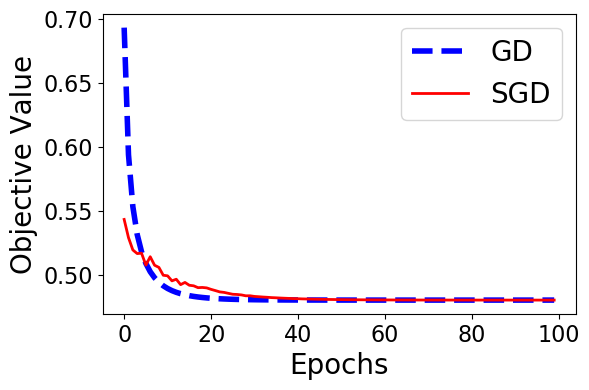

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(6, 4))

epochs_gd = range(len(objvals_gd))
epochs_sgd = range(len(objvals_sgd))

line0, = plt.plot(epochs_gd, objvals_gd, '--b', LineWidth=4)
line1, = plt.plot(epochs_sgd, objvals_sgd, '-r', LineWidth=2)
plt.xlabel('Epochs', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=16)
plt.yticks(FontSize=16)
plt.legend([line0, line1], ['GD', 'SGD'], fontsize=20)
plt.tight_layout()
plt.show()
fig.savefig('compare_gd_sgd.pdf', format='pdf', dpi=1200)

# 5. Prediction

In [15]:
# Predict class label
# Inputs:
#     w: d-by-1 matrix
#     X: m-by-d matrix
# Return:
#     f: m-by-1 matrix, the predictions
def predict(w, X):
    xw = numpy.dot(X, w)
    f = numpy.sign(xw)
    return f

In [16]:
# evaluate training error
f_train = predict(w, x_train)
diff = numpy.abs(f_train - y_train) / 2
error_train = numpy.mean(diff)
print('Training classification error is ' + str(error_train))

Training classification error is 0.2203125


In [17]:
# evaluate test error
f_test = predict(w, x_test)
diff = numpy.abs(f_test - y_test) / 2
error_test = numpy.mean(diff)
print('Test classification error is ' + str(error_test))

Test classification error is 0.21875


# 6. Mini-batch SGD (fill the code)

## 6.1. Compute the objective $Q_I$ and its gradient using a batch of samples

Define $Q_I (w) = \frac{1}{b} \sum_{i \in I} \log \Big( 1 + \exp \big( - y_i x_i^T w \big) \Big) + \frac{\lambda}{2} \| w \|_2^2 $, where $I$ is a set containing $b$ indices randomly drawn from $\{ 1, \cdots , n \}$ without replacement.

The stochastic gradient at $w$ is $g_I = \frac{\partial Q_I }{ \partial w} = \frac{1}{b} \sum_{i \in I} \frac{- y_i x_i }{1 + \exp ( y_i x_i^T w)} + \lambda w$.

In [19]:
# Calculate the objective Q_I and the gradient of Q_I
# Inputs:
#     w: d-by-1 matrix
#     xi: b-by-d matrix
#     yi: b-by-1 matrix
#     lam: scalar, the regularization parameter
#     b: integer, the batch size
# Return:
#     obj: scalar, the objective Q_i
#     g: d-by-1 matrix, gradient of Q_i
def mb_stochastic_objective_gradient(w, xi, yi, lam, b):
    # Fill the function
    # Follow the implementation of stochastic_objective_gradient
    # Use matrix-vector multiplication; do not use FOR LOOP of vector-vector multiplications
    # Compute the objective value for the mini-batch
    obj = objective(w, xi, yi, lam)
    
    # Compute the gradient for the mini-batch
    g = gradient(w, xi, yi, lam)
    
    return obj, g

## 6.2. Implement mini-batch SGD

Hints:
1. In every epoch, randomly permute the $n$ samples (just like SGD).
2. Each epoch has $\frac{n}{b}$ iterations. In every iteration, use $b$ samples, and compute the gradient and objective using the ``mb_stochastic_objective_gradient`` function. In the next iteration, use the next $b$ samples, and so on.


In [22]:
import numpy as np
# Mini-Batch SGD for solving logistic regression
# Inputs:
#     x: n-by-d matrix
#     y: n-by-1 matrix
#     lam: scalar, the regularization parameter
#     b: integer, the batch size
#     stepsize: scalar
#     max_epoch: integer, the maximal epochs
#     w: d-by-1 matrix, initialization of w
# Return:
#     w: the solution
#     objvals: record of each iteration's objective value
def mb_sgd(x, y, lam, b, stepsize, max_epoch=100, w=None):
    # Fill the function
    # Follow the implementation of sgd
    # Record one objective value per epoch (not per iteration!)
    n, d = x.shape
    objvals = np.zeros(max_epoch) # Store the objective values per epoch
    if w is None:
        w = np.zeros((d, 1)) # Zero initialization
    
    for t in range(max_epoch):
        # Randomly shuffle the dataset
        rand_indices = np.random.permutation(n)
        x_rand = x[rand_indices, :]
        y_rand = y[rand_indices, :]
        
        # Iterate over mini-batches
        for i in range(0, n, b):
            xi = x_rand[i:i+b, :]
            yi = y_rand[i:i+b, :]
            
            # Compute the gradient for the mini-batch
            _, g = mb_stochastic_objective_gradient(w, xi, yi, lam, b)
            
            # Update weights
            w -= stepsize * g
        
        # Evaluate and record the objective value for the entire dataset
        objval = objective(w, x, y, lam)
        objvals[t] = objval
        print(f'Objective value at epoch {t+1} is {objval}')
    
    return w, objvals

## 6.3. Run MB-SGD

In [36]:
# MB-SGD with batch size b=8
lam = 1E-6 # do not change
b = 8 # do not change
stepsize = 0.1 # you must tune this parameter

w, objvals_mbsgd8 = mb_sgd(x_train, y_train, lam, b, stepsize)

Objective value at epoch 1 is 0.49939142570367195
Objective value at epoch 2 is 0.4852183597785766
Objective value at epoch 3 is 0.4819266819974995
Objective value at epoch 4 is 0.48085715707798965
Objective value at epoch 5 is 0.4816302791141741
Objective value at epoch 6 is 0.481377614442648
Objective value at epoch 7 is 0.48109290184582154
Objective value at epoch 8 is 0.48139164558802794
Objective value at epoch 9 is 0.48167049122896927
Objective value at epoch 10 is 0.4818263701949071
Objective value at epoch 11 is 0.4805702943950212
Objective value at epoch 12 is 0.4815311228781036
Objective value at epoch 13 is 0.4817869813444136
Objective value at epoch 14 is 0.48116689284794456
Objective value at epoch 15 is 0.48076553152136975
Objective value at epoch 16 is 0.4804081888055275
Objective value at epoch 17 is 0.48063232629772673
Objective value at epoch 18 is 0.4833434489564195
Objective value at epoch 19 is 0.4806902117157816
Objective value at epoch 20 is 0.48046377248109834
O

In [34]:
# MB-SGD with batch size b=64
lam = 1E-6 # do not change
b = 64 # do not change
stepsize = 0.1 # you must tune this parameter

w, objvals_mbsgd64 = mb_sgd(x_train, y_train, lam, b, stepsize)

Objective value at epoch 1 is 0.6056371527632514
Objective value at epoch 2 is 0.5635367612183478
Objective value at epoch 3 is 0.539184948842398
Objective value at epoch 4 is 0.5235950233351936
Objective value at epoch 5 is 0.5132164917052306
Objective value at epoch 6 is 0.5057814682228001
Objective value at epoch 7 is 0.5003518020776604
Objective value at epoch 8 is 0.49631520762286013
Objective value at epoch 9 is 0.49321647266015844
Objective value at epoch 10 is 0.49078543962094096
Objective value at epoch 11 is 0.4888643125610222
Objective value at epoch 12 is 0.48733921068071184
Objective value at epoch 13 is 0.4861105692151336
Objective value at epoch 14 is 0.485122815298564
Objective value at epoch 15 is 0.48431132668988364
Objective value at epoch 16 is 0.4836215817160771
Objective value at epoch 17 is 0.483065809886887
Objective value at epoch 18 is 0.48260930360882576
Objective value at epoch 19 is 0.4822345073826571
Objective value at epoch 20 is 0.4819177715014526
Object

# 7. Plot and compare GD, SGD, and MB-SGD

You are required to compare the following algorithms:

- Gradient descent (GD)

- SGD

- MB-SGD with b=8

- MB-SGD with b=64

Follow the code in Section 4 to plot ```objective function value``` against ```epochs```. There should be four curves in the plot; each curve corresponds to one algorithm.

Hint: Logistic regression with $\ell_2$-norm regularization is a strongly convex optimization problem. All the algorithms will converge to the same solution. **In the end, the ``objective function value`` of the 4 algorithms will be the same. If not the same, your implementation must be wrong. Do NOT submit wrong code and wrong result!**

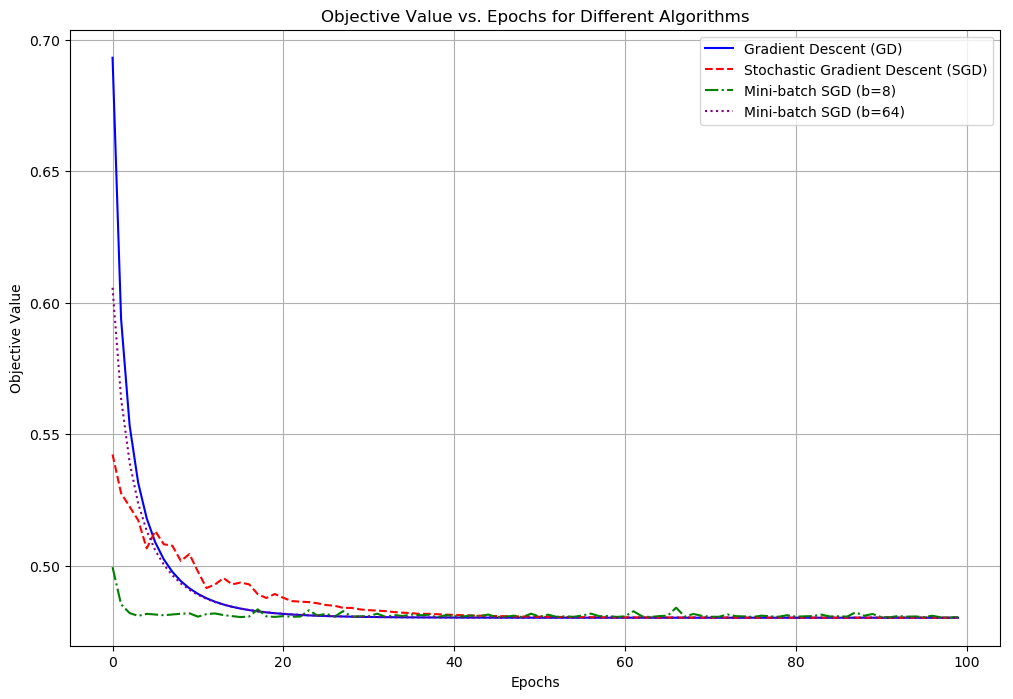

In [38]:
# plot the 4 curves:
plt.figure(figsize=(12, 8))
plt.plot(objvals_gd, label="Gradient Descent (GD)", linestyle="-", color="blue")
plt.plot(objvals_sgd, label="Stochastic Gradient Descent (SGD)", linestyle="--", color="red")
plt.plot(objvals_mbsgd8, label="Mini-batch SGD (b=8)", linestyle="-.", color="green")
plt.plot(objvals_mbsgd64, label="Mini-batch SGD (b=64)", linestyle=":", color="purple")
plt.xlabel("Epochs")
plt.ylabel("Objective Value")
plt.title("Objective Value vs. Epochs for Different Algorithms")
plt.legend()
plt.grid(True)
plt.show()

In [47]:
import pandas as pd
# Displaying the first 10 and last 10 rows
objective_values_df_display = pd.concat([objective_values_df.head(10), objective_values_df.tail(10)])
objective_values_df_display

,Gradient Descent (GD),Stochastic Gradient Descent (SGD),Mini-batch SGD (b=8),Mini-batch SGD (b=64)
0,0.693147,0.542259,0.499391,0.605637
1,0.593770,0.527533,0.485218,0.563537
2,0.553252,0.522388,0.481927,0.539185
3,0.531487,0.517255,0.480857,0.523595
4,0.517953,0.506534,0.481630,0.513216
5,0.508830,0.513113,0.481378,0.505781
6,0.502365,0.508093,0.481093,0.500352
7,0.497626,0.507546,0.481392,0.496315
8,0.494067,0.501732,0.481670,0.493216
9,0.491343,0.504387,0.481826,0.490785
